In [1]:
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import intake
import glob

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
import cmocean.cm as cm

from dask.distributed import Client

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42623,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:44141,Total threads: 1
Dashboard: /proxy/45517/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:41917,


In [3]:
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/*/*ocean_month_z.nc'))[120:]
pathsMW = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/*/*ocean_month_z.nc'))

In [4]:
def preprocessC(control):
    control = control[['thetao', 'so']].sel(yh = slice(None, -55))
    return control

def preprocessMW(perturbation):
    perturbation = perturbation[['thetao', 'so']].sel(yh = slice(None, -55))
    return perturbation

# control = xr.open_mfdataset(pathsC, preprocess = preprocessC)
# perturbation = xr.open_mfdataset(pathsMW, preprocess = preprocessMW)

In [5]:
area = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')['areacello']
total_area = area.cf.sum({'longitude', 'latitude'}).load()

In [ ]:
for n in range(len(pathsMW)):
    control = xr.open_mfdataset(pathsC[2*n:2*n+2], preprocess = preprocessC)
    perturbation = xr.open_mfdataset(pathsMW[n], preprocess = preprocessMW)

    anomaly = perturbation - control

    temp_hov = (area * anomaly['thetao']).cf.sum({'longitude', 'latitude'}) / total_area
    salt_hov = (area * anomaly['so']).cf.sum({'longitude', 'latitude'}) / total_area

    temp_hov.to_netcdf('/g/data/g40/kc5856/tmp/temp_anom_hovmoller_005_tmp_'+str(n).zfill(2)+'.nc')
    salt_hov.to_netcdf('/g/data/g40/kc5856/tmp/salt_anom_hovmoller_005_tmp_'+str(n).zfill(2)+'.nc')


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 33.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 33.62 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 33.63 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 33.62 MiB.
This may cause some slowd

In [6]:
temperature_hov = np.sort(glob.glob('/g/data/g40/kc5856/tmp/temp_anom_hovmoller_005_tmp_*'))
salinity_hov = np.sort(glob.glob('/g/data/g40/kc5856/tmp/salt_anom_hovmoller_005_tmp_*'))

In [15]:
TEMP_hov = xr.open_mfdataset(temperature_hov)
SALT_hov = xr.open_mfdataset(salinity_hov)

In [7]:
def plot_hovmoller(fsize = 14, date_format = mdates.DateFormatter('%Y')):
    
    # Set figures properties
    plt.rcParams['font.size'] = fsize
    plt.rcParams['xtick.labelsize'] = fsize-2
    plt.rcParams['ytick.labelsize'] = fsize-2
    
    fig = plt.figure(figsize = (10, 6))
    grid = GridSpec(100, 100)
    
    ax = [fig.add_subplot(grid[:30, :30]), fig.add_subplot(grid[:30, 33:63]),
          fig.add_subplot(grid[32:, :30]), fig.add_subplot(grid[32:, 33:63])]
    
    for i in range(len(ax)):
        ax[i].xaxis.set_major_formatter(date_format)
        ax[i].tick_params(axis='x', labelrotation=45)
        if i != 0 and i != 2:
            ax[i].set_yticklabels([]) 

    return fig, ax

In [20]:
SALT_hov

<xarray.Dataset> Size: 34kB
Dimensions:                        (time: 110, z_l: 75)
Coordinates:
  * z_l                            (z_l) float64 600B 0.5413 1.681 ... 5.709e+03
  * time                           (time) object 880B 2001-01-16 12:00:00 ......
Data variables:
    __xarray_dataarray_variable__  (time, z_l) float32 33kB dask.array<chunksize=(2, 75), meta=np.ndarray>

AttributeError: 'Dataset' object has no attribute 'ndim'

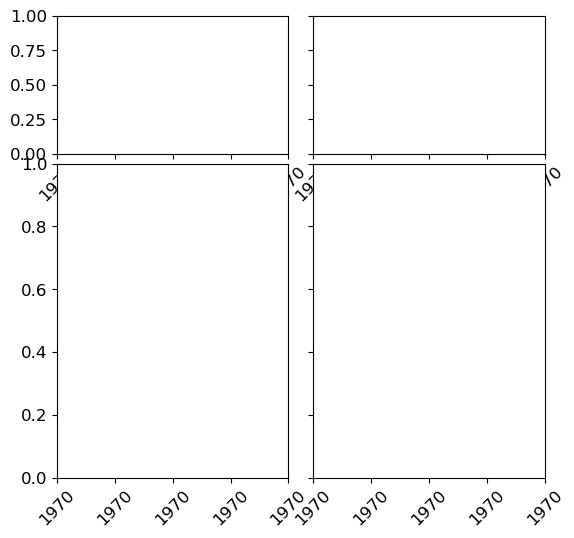

In [17]:
fig, ax = plot_hovmoller(fsize = 14)

levels_temperature = np.arange(-0.3, 0.31, 0.01)

cf_temp = TEMP_hov.cf.plot(ax = ax[0],
                                  levels = levels_temperature,
                                  x = 'time',
                                  y = 'vertical',
                                  add_colorbar = False,
                                  label = None,
                                  cmap = cm.balance)

TEMP_hov.cf.plot(ax = ax[2],
                        levels = levels_temperature,
                        x = 'time',
                        y = 'vertical',
                        add_colorbar = False,
                        label = None,
                        cmap = cm.balance)

levels_salinity = np.arange(-0.06, 0.061, 0.001)

cf_salt = SALT_hov.cf.plot(ax = ax[1],
                               levels = levels_salinity,
                               x = 'time',
                               y = 'vertical',
                               add_colorbar = False,
                               label = None,
                               cmap = cm.curl)

SALT_hov.cf.plot(ax = ax[3],
                     levels = levels_salinity,
                     x = 'time',
                     y = 'vertical',
                     add_colorbar = False,
                     label = None,
                     cmap = cm.curl)

## Beautification details
for i in range(len(ax)):
    if i < 2:
        ax[i].set_ylim(500, 0)
        ax[i].set_xlim(500,4000)
        ax[i].set_xticklabels([])
    else:
        ax[i].set_xlabel("")
        ax[i].set_xlim(500,4000)
        ax[i].set_ylim(5000, 500)
ax[0].set_ylabel("Depth [m]")
ax[1].set_ylabel("")
ax[2].set_ylabel("Depth [m]")
ax[3].set_ylabel("")

# Colorbars
bar = plt.axes([0.11, 0.99, 0.25, 0.02])
cbar_1 = plt.colorbar(cf_temp, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_1.set_label("Temperature [$\degree$C]")

bar = plt.axes([0.37, 0.99, 0.25, 0.02])
cbar_2 = plt.colorbar(cf_salt, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_2.set_label("Salinity [psu]")

for cbar in [cbar_1, cbar_2]:
    tick_locator = ticker.MaxNLocator(nbins=3) ## The ticker needs to called within the loop
    cbar.locator = tick_locator
    cbar.update_ticks()